# Overview

In this notebook, we preprocess the acquired TEM images and create the datasets used in "Influence of Receptive Field]{Understanding the Influence of Receptive Field and Network Complexity in Neural-Network-Guided TEM Image Analysis"

Preprocessing consists of:
*  Removing x-ray outliers
*  Standardizing each image
*  Splitting each image into 512x512 pixel patches
*  Splitting the dataset into training, validation, and test sets
*  Augmenting each set with the 8 dihedral transformations and then shuffling
*  Converting data into a PyTorch-compatible format

# Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
from preprocessing_routines import * 

# Low-Resolution Dataset

In [2]:
# Import the dataset and labels
dataset = h5py.File('Au_20nm_87kx_16e_Images.h5','r')['images']
labels = h5py.File('Au_20nm_87kx_16e_Labels.h5','r')['labels']

In [3]:
# Remove x-ray outliers and standardize images
img_list = []
lbl_list = []
for i in range(dataset.shape[0]):
    img = xray_correct_threshold(dataset[i,:,:],threshold=400)
    img_list.append(standardize(img))
    lbl_list.append(labels[i,:,:])

Number of detected x-rays: 32
Number of detected x-rays: 0
Number of detected x-rays: 22
Number of detected x-rays: 0
Number of detected x-rays: 14
Number of detected x-rays: 0
Number of detected x-rays: 20
Number of detected x-rays: 0
Number of detected x-rays: 36
Number of detected x-rays: 0
Number of detected x-rays: 16
Number of detected x-rays: 0
Number of detected x-rays: 14
Number of detected x-rays: 0
Number of detected x-rays: 31
Number of detected x-rays: 0
Number of detected x-rays: 34
Number of detected x-rays: 0
Number of detected x-rays: 34
Number of detected x-rays: 0
Number of detected x-rays: 20
Number of detected x-rays: 0
Number of detected x-rays: 34
Number of detected x-rays: 1
Number of detected x-rays: 17
Number of detected x-rays: 0
Number of detected x-rays: 15
Number of detected x-rays: 0
Number of detected x-rays: 11
Number of detected x-rays: 0
Number of detected x-rays: 24
Number of detected x-rays: 1
Number of detected x-rays: 25
Number of detected x-rays:

In [4]:
# Create 512x512 pixel patches and remove patches that have less than 400 pixels labeled as nanoparticle (i.e. > 98.5% background)
img_patches, lbl_patches = create_patches(img_list, lbl_list,patch_size=512)
img_patches, lbl_patches = remove_bkgd_patches(img_patches, lbl_patches, threshold=400)

In [5]:
# Split the data into training, validation, and test sets

split = [70,10,20] #Split sets the percentage for the training, validation, and test sets

valid_start = split[0]*img_patches.shape[0]//100
test_start = valid_start + split[1]*img_patches.shape[0]//100

train_dataset = img_patches[:valid_start,:,:]
train_labels = lbl_patches[:valid_start,:,:] 

valid_dataset = img_patches[valid_start:test_start,:,:]
valid_labels = lbl_patches[valid_start:test_start,:,:]

test_dataset = img_patches[test_start:,:,:]
test_labels = lbl_patches[test_start:,:,:]

print("Size of non-augmented training set: "+ str(train_dataset.shape))
print("Size of non-augmented validation set: "+ str(valid_dataset.shape))
print("Size of non-augmented test set: "+ str(test_dataset.shape))

Size of non-augmented training set: (92, 512, 512)
Size of non-augmented validation set: (13, 512, 512)
Size of non-augmented test set: (27, 512, 512)


In [6]:
#Expand dimensions such that the data is of the format (N,H,W,C)
train_dataset = np.expand_dims(train_dataset, axis=3)
train_labels = np.expand_dims(train_labels, axis=3)

valid_dataset = np.expand_dims(valid_dataset, axis=3)
valid_labels = np.expand_dims(valid_labels, axis=3)

test_dataset = np.expand_dims(test_dataset, axis=3)
test_labels = np.expand_dims(test_labels, axis=3)

In [7]:
#Augment and Shuffle
train_dataset, train_labels = dihedral_augmentation(train_dataset,train_labels)
train_dataset, train_labels = shuffle_dataset(train_dataset, train_labels, 7221)

valid_dataset, valid_labels = dihedral_augmentation(valid_dataset,valid_labels)
valid_dataset, valid_labels = shuffle_dataset(valid_dataset, valid_labels, 7222)

test_dataset, test_labels = dihedral_augmentation(test_dataset,test_labels)
test_dataset, test_labels = shuffle_dataset(test_dataset, test_labels, 7231)

In [8]:
#Convert to PyTorch format of (N,C,H,W) in float32 data type
train_dataset = pyTorch_format(train_dataset)
train_labels = pyTorch_format(train_labels)

valid_dataset = pyTorch_format(valid_dataset)
valid_labels = pyTorch_format(valid_labels)

test_dataset = pyTorch_format(test_dataset)
test_labels = pyTorch_format(test_labels)

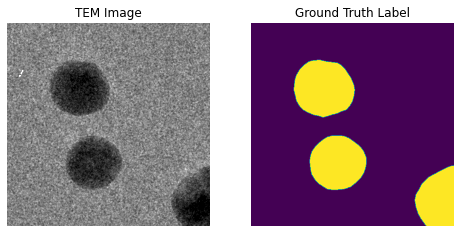

In [9]:
# Look at sample image
sample_num = 10
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(train_dataset[sample_num,0,:,:],cmap='gray')
plt.clim([-4,4])
plt.title('TEM Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(train_labels[sample_num,0,:,:])
plt.title('Ground Truth Label')
plt.axis('off');

In [ ]:
# Save h5 files
write_h5(train_dataset,'Au20Titan_Training_DiAugment_Std_PyTorch_Images.h5', 'images')
write_h5(train_labels,'Au20Titan_Training_DiAugment_Std_PyTorch_Labels.h5', 'labels')

write_h5(valid_dataset,'Au20Titan_Validation_DiAugment_Std_PyTorch_Images.h5', 'images')
write_h5(valid_labels,'Au20Titan_Validation_DiAugment_Std_PyTorch_Labels.h5', 'labels')

write_h5(test_dataset,'Au20Titan_Test_DiAugment_Std_PyTorch_Images.h5', 'images')
write_h5(test_labels,'Au20Titan_Test_DiAugment_Std_PyTorch_Labels.h5', 'labels')

# High-Resolution Dataset - 5nm from Groschner et al. (2021)

The dataset from Groschner et al. (2021) is already normalized and split into 512x512 pixel patches. We will just augment the dataset and make sure it's in the PyTorch format.

In [11]:
#Import the dataset and labels
dataset = h5py.File('Au_Bal_MedFilt_cutimages_20190726.h5','r')['images']
labels = h5py.File('Au_Bal_unFilt_cutimages_20190423_maps.h5','r')['maps']

In [12]:
# Split into training, validation, and test sets

split = [70,10,20] #Split sets the percentage for the training, validation, and test sets

valid_start = split[0]*dataset.shape[0]//100
test_start = valid_start + split[1]*dataset.shape[0]//100

train_dataset = dataset[:valid_start,:,:,:]
train_labels = labels[:valid_start,:,:,1:] #I'm going to take the 1st channel, which gives a 1 when it's a particle and a 0 when it's background

valid_dataset = dataset[valid_start:test_start,:,:,:]
valid_labels = labels[valid_start:test_start,:,:,1:]

test_dataset = dataset[test_start:,:,:,:]
test_labels = labels[test_start:,:,:,1:]

print("Size of non-augmented training set: "+ str(train_dataset.shape))
print("Size of non-augmented validation set: "+ str(valid_dataset.shape))
print("Size of non-augmented test set: "+ str(test_dataset.shape))

Size of non-augmented training set: (151, 512, 512, 1)
Size of non-augmented validation set: (21, 512, 512, 1)
Size of non-augmented test set: (44, 512, 512, 1)


In [13]:
# Augment and shuffle
train_aug, train_labels_aug = dihedral_augmentation(train_dataset,train_labels)
train_aug, train_labels_aug = shuffle_dataset(train_aug, train_labels_aug, 6235)

valid_aug, valid_labels_aug = dihedral_augmentation(valid_dataset,valid_labels)
valid_aug, valid_labels_aug = shuffle_dataset(valid_aug, valid_labels_aug, 785)

test_aug, test_labels_aug = dihedral_augmentation(test_dataset,test_labels)
test_aug, test_labels_aug = shuffle_dataset(test_aug, test_labels_aug, 278)

In [14]:
#Convert to PyTorch format of (N,C,H,W) in float32 data type
train_dataset = pyTorch_format(train_dataset)
train_labels = pyTorch_format(train_labels)

valid_dataset = pyTorch_format(valid_dataset)
valid_labels = pyTorch_format(valid_labels)

test_dataset = pyTorch_format(test_dataset)
test_labels = pyTorch_format(test_labels)

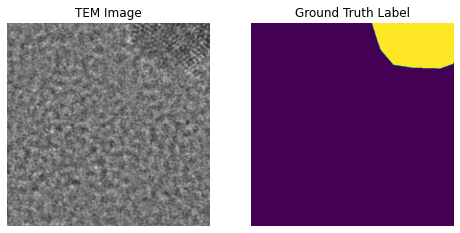

In [15]:
# Look at sample image
sample_num = 10
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(train_dataset[sample_num,0,:,:],cmap='gray')
plt.clim([0,1])
plt.title('TEM Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(train_labels[sample_num,0,:,:])
plt.title('Ground Truth Label')
plt.axis('off');

In [ ]:
# Save h5 files
write_h5(train_dataset,'Au_Training_DiAugment_Norm_PyTorch_Images.h5', 'images')
write_h5(train_labels,'Au_Training_DiAugment_Norm_PyTorch_Labels.h5', 'labels')

write_h5(valid_dataset,'Au_Validation_DiAugment_Norm_PyTorch_Images.h5', 'images')
write_h5(valid_labels,'Au_Validation_DiAugment_Norm_PyTorch_Labels.h5', 'labels')

write_h5(test_dataset,'Au_Test_DiAugment_Norm_PyTorch_Images.h5', 'images')
write_h5(test_labels,'Au_Test_DiAugment_Norm_PyTorch_Labels.h5', 'labels')

# High-Resolution Dataset - 2.2nm Au nanoparticles

In [16]:
# Import the dataset and labels
dataset = h5py.File('Au_2p2nm_330kx_423e_Images.h5','r')['images']
labels = h5py.File('Au_2p2nm_330kx_423e_Labels.h5','r')['labels']

In [17]:
# Remove x-ray outliers and standardize images
img_list = []
lbl_list = []
for i in range(dataset.shape[0]):
    img = xray_correct_threshold(dataset[i,:,:],threshold=1500)
    img_list.append(standardize(img))
    lbl_list.append(labels[i,:,:])

Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 4
Number of detected x-rays: 1
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 1
Number of detected x-rays: 0


In [18]:
# Create 512x512 pixel patches and remove patches that have less than 400 pixels labeled as nanoparticle (i.e. > 98.5% background)
img_patches, lbl_patches = create_patches(img_list, lbl_list,patch_size=512)
img_patches, lbl_patches = remove_bkgd_patches(img_patches, lbl_patches, threshold=400)

In [19]:
# Split into training, validation, and test sets
# All of the steps are compiled in the routine tvt_creation
train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels = tvt_creation(img_patches,lbl_patches,[70,10,20],91152)

Size of non-augmented training set: (248, 512, 512)
Size of non-augmented validation set: (35, 512, 512)
Size of non-augmented test set: (72, 512, 512)


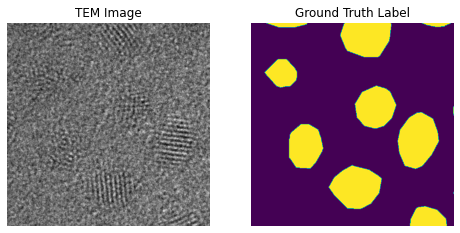

In [21]:
# Look at sample image
sample_num = 10
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(train_dataset[sample_num,0,:,:],cmap='gray')
plt.clim([-4,4])
plt.title('TEM Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(train_labels[sample_num,0,:,:])
plt.title('Ground Truth Label')
plt.axis('off');

In [ ]:
write_h5(train_dataset,'Au2p2_Training_DiAugment_Std_PyTorch_Images.h5', 'images')
write_h5(train_labels,'Au2p2_Training_DiAugment_Std_PyTorch_Labels.h5', 'labels')

write_h5(valid_dataset,'Au2p2_Validation_DiAugment_Std_PyTorch_Images.h5', 'images')
write_h5(valid_labels,'Au2p2_Validation_DiAugment_Std_PyTorch_Labels.h5', 'labels')

write_h5(test_dataset,'Au2p2_Test_DiAugment_Std_PyTorch_Images.h5', 'images')
write_h5(test_labels,'Au2p2_Test_DiAugment_Std_PyTorch_Labels.h5', 'labels')

# High-Resolution Dataset - 5nm Au nanoparticles

In [22]:
# Import the dataset and labels
dataset = h5py.File('Au_5nm_330kx_423e_Images.h5','r')['images']
labels = h5py.File('Au_5nm_330kx_423e_Labels.h5','r')['labels']

In [23]:
# Remove x-ray outliers and standardize images
img_list = []
lbl_list = []
for i in range(dataset.shape[0]):
    img = xray_correct_threshold(dataset[i,:,:],threshold=1500)
    img_list.append(standardize(img))
    lbl_list.append(labels[i,:,:])

Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 1
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 4
Number of detected x-rays: 1
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0


In [24]:
# Create 512x512 pixel patches and remove patches that have less than 400 pixels labeled as nanoparticle (i.e. > 98.5% background)
img_patches, lbl_patches = create_patches(img_list, lbl_list,patch_size=512)
img_patches, lbl_patches = remove_bkgd_patches(img_patches, lbl_patches, threshold=400)

In [25]:
# Split into training, validation, and test sets
train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels = tvt_creation(img_patches,lbl_patches,[70,10,20],61882)

Size of non-augmented training set: (147, 512, 512)
Size of non-augmented validation set: (21, 512, 512)
Size of non-augmented test set: (43, 512, 512)


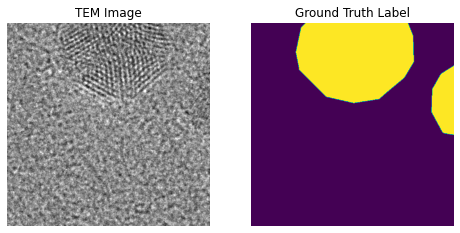

In [26]:
# Look at sample image
sample_num = 10
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(train_dataset[sample_num,0,:,:],cmap='gray')
plt.clim([-4,4])
plt.title('TEM Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(train_labels[sample_num,0,:,:])
plt.title('Ground Truth Label')
plt.axis('off');

In [ ]:
# Save h5 files
write_h5(train_dataset,'Au5nm330kx_Training_DiAugment_Std_PyTorch_Images.h5', 'images')
write_h5(train_labels,'Au5nm330kx_Training_DiAugment_Std_PyTorch_Labels.h5', 'labels')

write_h5(valid_dataset,'Au5nm330kx_Validation_DiAugment_Std_PyTorch_Images.h5', 'images')
write_h5(valid_labels,'Au5nm330kx_Validation_DiAugment_Std_PyTorch_Labels.h5', 'labels')

write_h5(test_dataset,'Au5nm330kx_Test_DiAugment_Std_PyTorch_Images.h5', 'images')
write_h5(test_labels,'Au5nm330kx_Test_DiAugment_Std_PyTorch_Labels.h5', 'labels')

# High-Resolution Dataset - 10nm Au nanoparticles

In [27]:
# Import the dataset and labels
dataset = h5py.File('Au_10nm_330kx_425e_Images.h5','r')['images']
labels = h5py.File('Au_10nm_330kx_425e_Labels.h5','r')['labels']

In [28]:
# Remove x-ray outliers and standardize images
img_list = []
lbl_list = []
for i in range(dataset.shape[0]):
    img = xray_correct_threshold(dataset[i,:,:],threshold=1500)
    img_list.append(standardize(img))
    lbl_list.append(labels[i,:,:])

Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 9
Number of detected x-rays: 6
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0
Number of detected x-rays: 0


In [29]:
# Create 512x512 pixel patches and remove patches that have less than 400 pixels labeled as nanoparticle (i.e. > 98.5% background)
img_patches, lbl_patches = create_patches(img_list, lbl_list,patch_size=512)
img_patches, lbl_patches = remove_bkgd_patches(img_patches, lbl_patches, threshold=400)

In [30]:
# Split into training, validation, and test sets
train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels = tvt_creation(img_patches,lbl_patches,[70,10,20],25224)

Size of non-augmented training set: (89, 512, 512)
Size of non-augmented validation set: (12, 512, 512)
Size of non-augmented test set: (27, 512, 512)


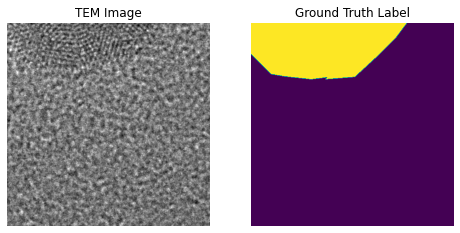

In [31]:
# Look at sample image
sample_num = 10
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(train_dataset[sample_num,0,:,:],cmap='gray')
plt.clim([-4,4])
plt.title('TEM Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(train_labels[sample_num,0,:,:])
plt.title('Ground Truth Label')
plt.axis('off');

In [ ]:
# Save h5 files
write_h5(train_dataset,'Au10_330kx_Training_DiAugment_Std_PyTorch_Images.h5', 'images')
write_h5(train_labels,'Au10_330kx_Training_DiAugment_Std_PyTorch_Labels.h5', 'labels')

write_h5(valid_dataset,'Au10_330kx_Validation_DiAugment_Std_PyTorch_Images.h5', 'images')
write_h5(valid_labels,'Au10_330kx_Validation_DiAugment_Std_PyTorch_Labels.h5', 'labels')

write_h5(test_dataset,'Au10_330kx_Test_DiAugment_Std_PyTorch_Images.h5', 'images')
write_h5(test_labels,'Au10_330kx_Test_DiAugment_Std_PyTorch_Labels.h5', 'labels')